In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

##packages need

In [2]:
def read_data(path):
    
    df=pd.read_csv(path)
    l=[]
    for v in df['credit'].values:
        if v==2.0:
            l.append(0)
        else:
            l.append(1)
    df['credit']=l

    orig_df=df


    featlst=list(df.columns)
    featlst.remove('credit')


    for feat in featlst:
        highest=max(df[feat])
        lowest=min(df[feat])
        #if len(list(set(df[feat])))>4:
        #    print (feat,len(list(set(df[feat]))))
        l=df[feat]
        if feat=='month':
            processed=[]
            for v in l:
                if v<=10:
                    processed.append(0)
                elif v<15:
                    processed.append(1)
                elif v<25:
                    processed.append(2)
                else:
                    processed.append(3)
            df[feat]=processed
        if feat=='housing':
            print (feat)
            processed=[]
            for v in l:
                if v==1:
                    processed.append(1)
                else:
                    processed.append(0)
            df[feat]=processed
        
        if feat=='installment_plans' or feat=='number_of_credits':
            print (feat)
            processed=[]
            for v in l:
                if v<=1:
                    processed.append(0)
                else:
                    processed.append(1)
            df[feat]=processed
        if feat=='employment' or feat=='credit_history' or feat=='skill_level':
            print (feat)
            processed=[]
            for v in l:
                if v<=1:
                    processed.append(0)
                else:
                    processed.append(v)
            df[feat]=processed
            
        if feat=='credit_amount':
            processed=[]
            for v in l:
                if v<=1500:
                    processed.append(0)
                elif v<3000:
                    processed.append(1)
                elif v<5500:
                    processed.append(2)
                else:
                    processed.append(3)
            df[feat]=processed
        if feat=='purpose':
            l=[]
            for v in df['purpose']:
                if v>4:
                    l.append(5)
                elif v<=2:
                    l.append(2)
                else:
                    l.append(v)
            df[feat]=l
        if feat=='other_debtors':
            processed=[]
            for v in l:
                if v<=0:
                    processed.append(0)
                else:
                    processed.append(1)
            df[feat]=processed
        if feat=='savings':
            processed=[]
            for v in l:
                if v<=0:
                    processed.append(0)
                elif v<=3:
                    processed.append(1)
                else:
                    processed.append(2)
            df[feat]=processed
        #    #pd.cut(l)
        #    range_lst=pd.cut(l,4,labels=[0,1,2,3])
        #    df[feat]=(pd.cut(l,4,labels=[0,1,2,3]))



    return df

## this function is from hyper

In [3]:
p='/Users/wangning/Desktop/Hyper-Code/reproducibility/scripts/datasets/german.csv'
df=read_data(p)
df.head()

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
0,0,1.0,1,1,0,1,4.0,4.0,1.0,1,...,4.0,0.0,0.0,4.0,1.0,1.0,0,0.0,2.0,2
1,3,0.0,0,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.0,2.0,0
2,1,1.0,1,1,1,0,3.0,5.0,1.0,1,...,4.0,0.0,0.0,2.0,2.0,0.0,0,3.0,0.0,0
3,3,1.0,1,1,3,0,3.0,3.0,1.0,0,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.0,2.0,0
4,2,1.0,0,1,2,1,2.0,2.0,1.0,0,...,3.0,3.0,0.0,3.0,2.0,0.0,0,0.0,2.0,0


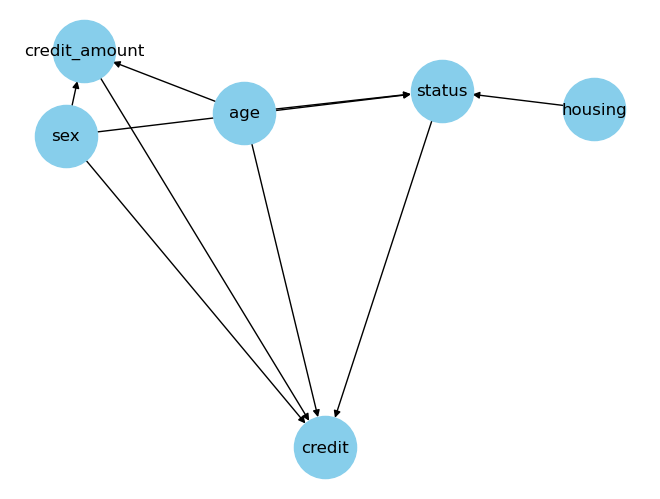

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue")
plt.show()

In [5]:
def get_new_G(G,df):
    """
    G: the causal graph
    df: the dataframe
    """
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    col1s=[]
    col2s=[]
    for u, v in G.edges:
        col1s.append(u)
        col2s.append(v)
    new_G = nx.DiGraph()
    for i in range(len(col1s)):
        X = sm.add_constant(df[col1s[i]])
        model = sm.OLS(df[col2s[i]], X).fit()
        new_G.add_edge(col1s[i], col2s[i], weight=model.params[col1s[i]])
        
    return new_G


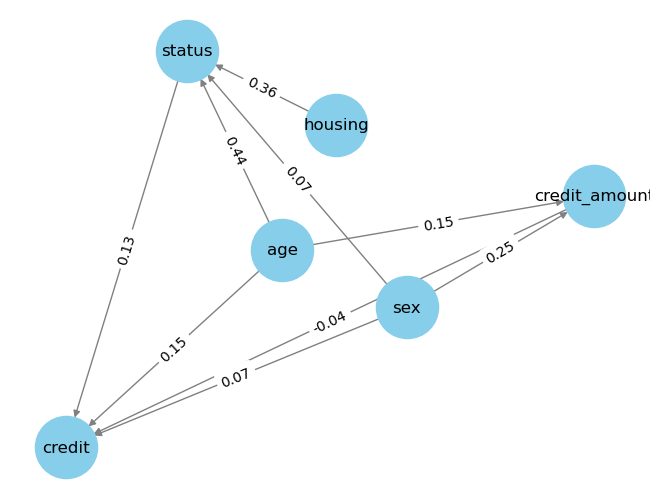

In [6]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()
    

In [7]:
def adjust_node(node, delta, df_temp, G, condition_mask, updated_val, is_first_iteration=True):
    """
    node: the updtaed column
    delta: a list of delta between the updated value and the original value
    df_temp:  dataframe
    G: the causal graph
    condition mask: a list of boolean to filter the rows
    updated_val: the updated value which the columns will be setted to
    is_first_iteration: a boolean to make sure only the updated column is to be setted with updated val
    """
    for _, child, data in G.out_edges(node, data=True):
        d_w = data['weight']
        child_delta = [d_w*d for d in delta]
        df_temp.loc[condition_mask, child] += child_delta
        # recursion for children of children
        adjust_node(child, child_delta, df_temp, G, condition_mask, updated_val, is_first_iteration=False)
        
        if is_first_iteration:
            df_temp.loc[condition_mask, node] = updated_val
            
    return df_temp


In [8]:
def ranking_query(G, df, k, update_vars, target_column, condition=None):
    """
    G: the causal graph
    df:  dataframe
    k: the top k
    update_vars: the variables need to be updated with the value
    target_column: the column we will rank by
    condition:the condtion to filter rows
    """
    df_temp = df.copy()
    #filter rows with the condtions
    if condition:
        condition_mask = df_temp[list(condition.keys())].eq(pd.Series(condition)).all(axis=1)
    else:
        condition_mask = pd.Series([True]*len(df_temp))

    for var, value in update_vars.items():
        temp_lst=df_temp.loc[condition_mask, var]
        delta = [value - x for x in temp_lst]
        adjust_node(var, delta, df_temp, G, condition_mask,value,True)

    top_k_values = [float('-inf')] * k
    top_k_indices = [-1] * k
    
    # greedy method
    for index, row in df_temp.iterrows():
        min_top_k = min(top_k_values)
        if row[target_column] > min_top_k:
            min_index = top_k_values.index(min_top_k)
            top_k_values[min_index] = row[target_column]
            top_k_indices[min_index] = index

    return df_temp.loc[top_k_indices]


In [9]:
def backdoor_adjustment(df, Y, y, A, a, Z):
    """
    Compute p(Y = y | do(A) = a) using the backdoor criterion.
    
    Args:
    - df: DataFrame with data.
    - Y: Outcome variable name.
    - y: Specific value of Y.
    - A: Intervention variable name.
    - a: Specific value of A for the intervention.
    - Z: List of variables that satisfy the backdoor criterion.
    
    Returns:
    - Probability p(Y = y | do(A) = a).
    """
    
    prob = 0
    for z_values in df[Z].drop_duplicates().values:
        
        z_values_tuple = tuple(z_values)
        z_mask = (df[Z].apply(tuple, axis=1) == z_values_tuple)
        num = len(df[z_mask & (df[A] == a) & (df[Y] == y)])
        den = len(df[z_mask & (df[A] == a)])
        p_Y_given_A_Z = num / den if den != 0 else 0
        p_Z = len(df[z_mask]) / len(df)
        
        if den != 0:
            p_Y_given_A_Z = num / den 
            p_Z = len(df[z_mask]) / len(df)
            prob += p_Y_given_A_Z * p_Z

    return prob

In [10]:
def find_backdoor_sets(G, nodes):
    """
    G: causal graph
    nodes: the nodes in casaul graph
    """
    backdoor_sets = defaultdict(list)
    for node in nodes:
        for adj_node in G.predecessors(node):
            backdoor_sets[node].append(adj_node)
    return backdoor_sets

In [11]:
def get_prob_backdoor(df,G,y):
    """
    df: dataframe
    G: causal graph
    y: the target node
    """
    backdoor_sets = find_backdoor_sets(G, G.nodes())
    for node, bd_set in backdoor_sets.items():
        if node != y:
            dom_y = df[y].unique()
            dom_node = df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment(df, y, d_y, node, d_n, bd_set)
                    print(f"P({y} = {d_y}|{node} = {d_n} & {bd_set}: {adjusted_prob})")

In [12]:
def comp_rank_k(df, y, k):
    """
    df: dataframe
    y: the target node
    k: numbers of element in a comparision,[e1,e2,...ek]
    """
    length = len(df.index)
    scores = df[y].tolist()
    prob_df = pd.DataFrame(0, index=df.index, columns=range(1, k+1))
    prob_df['row_index'] = prob_df.index
    cols = prob_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    prob_df = prob_df[cols]
    
    for rank in range(1, k+1):
        for i, score in enumerate(scores):
            higher_counts = sum(1 for s in scores if s > score)
            same_counts = sum(1 for s in scores if s == score)
            if higher_counts < rank <= higher_counts + same_counts:
                prob_df.loc[i, rank] = 1 / same_counts
    
    return prob_df

In [13]:
def ranking_query_prob(G, df, k, update_vars, target_column, condition=None):
    """
    G: the causal graph
    df:  dataframe
    k: the top k
    update_vars: the variables need to be updated with the value
    target_column: the column we will rank by
    condition:the condtion to filter rows
    """
    df_temp = df.copy()
    #filter rows with the condtions
    if condition:
        condition_mask = df_temp[list(condition.keys())].eq(pd.Series(condition)).all(axis=1)
    else:
        condition_mask = pd.Series([True]*len(df_temp))

    for var, value in update_vars.items():
        temp_lst=df_temp.loc[condition_mask, var]
        delta = [value - x for x in temp_lst]
        adjust_node(var, delta, df_temp, G, condition_mask,value,True)
    
    prob_df=comp_rank_k(df_temp, target_column, k)
    
    return prob_df

In [14]:
def filter_prob_df(df):
    """
    df: a probility dataframe generated by ranking_query_prob
    """
    df_edit = df.columns[1:]
    filtered_df = df.loc[df[df_edit].apply(lambda x: any(v != 0 for v in x), axis=1)]
    return filtered_df

In [15]:
def calc_prob(df,n):
    """
    df: a probility dataframe generated by ranking_query_prob or filter_prob_df
    n: top n comparision ranking like for n=3 is like [1,2,3,4,5],[2,5,6,3,1],[1,3,6,4,7]
    """
    results = []
    perms = itertools.permutations(df.index, len(df.columns)-1)
    
    for perm in perms:
        prob_vals = []
        for rank, index in enumerate(perm, start=1):
            prob = df.loc[index, rank]
            prob_vals.append(prob)
        
        result_prob = np.prod(prob_vals)
        results.append({"ranking_combos": perm, "probabilities": result_prob})
    results.sort(key=lambda x: x['probabilities'], reverse=True)
    total_prob = sum(result['probabilities'] for result in results)
    for result in results:
        result['probabilities'] /= total_prob
    top_results = results[:n]
    
    return top_results

In [17]:
def get_probs(df, row_indices):
    product = 1  
    for i, row_index in enumerate(row_indices):
        col_name = i+1
        value = df.loc[df['row_index'] == row_index, col_name].values[0]
        if value == 0:
            return 0
        product *= value
        
        # Adjusting the next rank's probability
        if value != 0 and value != 1:
            next_index = i+1
            if next_index < len(row_indices):
                next_row_index = row_indices[next_index]
                remaining_prob = 1 - value
                adjusted_value = value / remaining_prob
                df.loc[df['row_index'] == next_row_index, col_name+1] = adjusted_value
                
    return product

In [18]:
def base_line(df,k):
    prob=1/(m.perm(len(df), k))
    return prob


### Baseline model
- our baseline is $\frac{1}{^nP_k}$ for all pwd where k is the top k and n is the length of the data.

In [19]:
update_vars = {'age': 3}
tok_k_prob = ranking_query_prob(new_G, df, 5, update_vars, 'credit',{'month':3})
tok_k_prob

,row_index,1,2,3,4,5
0,0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
995,995,0.0,0.0,0.0,0.0,0.0
996,996,0.0,0.0,0.0,0.0,0.0
997,997,0.0,0.0,0.0,0.0,0.0
998,998,0.0,0.0,0.0,0.0,0.0


In [20]:
prob_df_filtered=filter_prob_df(tok_k_prob)
prob_df_filtered

,row_index,1,2,3,4,5
17,17,0.071429,0.071429,0.071429,0.071429,0.071429
43,43,0.071429,0.071429,0.071429,0.071429,0.071429
69,69,0.071429,0.071429,0.071429,0.071429,0.071429
79,79,0.071429,0.071429,0.071429,0.071429,0.071429
101,101,0.071429,0.071429,0.071429,0.071429,0.071429
130,130,0.071429,0.071429,0.071429,0.071429,0.071429
134,134,0.071429,0.071429,0.071429,0.071429,0.071429
152,152,0.071429,0.071429,0.071429,0.071429,0.071429
217,217,0.071429,0.071429,0.071429,0.071429,0.071429
306,306,0.071429,0.071429,0.071429,0.071429,0.071429


In [21]:
ranking_query(new_G, df, 5, update_vars, 'credit',{'month':3})

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
43,3,3.0,1.59899,1,3.447953,1,3.0,2.0,1.0,0,...,4.0,2.0,0.0,1.0,1.0,0.0,0,1.318324,2.0,1
17,3,3.0,1.59899,0,3.447953,1,0.0,5.0,1.0,1,...,0.0,2.0,0.0,2.0,1.0,0.0,0,1.318324,2.0,2
69,3,3.0,1.59899,1,1.447953,0,2.0,4.0,0.0,1,...,2.0,2.0,0.0,4.0,1.0,0.0,0,4.318324,2.0,2
79,3,3.0,1.59899,1,2.447953,0,0.0,3.0,1.0,1,...,2.0,1.0,0.0,2.0,1.0,0.0,0,2.318324,2.0,0
101,3,3.0,1.59899,1,1.447953,0,3.0,4.0,1.0,0,...,2.0,2.0,0.0,4.0,1.0,0.0,0,2.318324,2.0,0


In [22]:
m.perm(14, 5)*4.162504162483899e-06

0.9999999999951319

In [23]:
calc_prob(prob_df_filtered,5)

[{'ranking_combos': (17, 43, 69, 79, 101),
  'probabilities': 4.162504162483899e-06},
 {'ranking_combos': (17, 43, 69, 79, 130),
  'probabilities': 4.162504162483899e-06},
 {'ranking_combos': (17, 43, 69, 79, 134),
  'probabilities': 4.162504162483899e-06},
 {'ranking_combos': (17, 43, 69, 79, 152),
  'probabilities': 4.162504162483899e-06},
 {'ranking_combos': (17, 43, 69, 79, 217),
  'probabilities': 4.162504162483899e-06}]

In [24]:
get_probs(tok_k_prob,[17, 43, 69, 79, 101])

4.162504162504157e-06

In [25]:
get_probs(tok_k_prob,[1, 43, 69, 79, 101])

0

In [26]:
base_line(df,5)

1.0100653517088042e-15

In [27]:
get_prob_backdoor(df,G,'credit')

P(credit = 1|status = 0.0 & ['sex', 'housing', 'age']: 0.5168046651916438)
P(credit = 1|status = 1.0 & ['sex', 'housing', 'age']: 0.6248214975845411)
P(credit = 1|status = 3.0 & ['sex', 'housing', 'age']: 0.8797446426573545)
P(credit = 1|status = 2.0 & ['sex', 'housing', 'age']: 0.7813333333333335)
P(credit = 0|status = 0.0 & ['sex', 'housing', 'age']: 0.4831953348083562)
P(credit = 0|status = 1.0 & ['sex', 'housing', 'age']: 0.37517850241545886)
P(credit = 0|status = 3.0 & ['sex', 'housing', 'age']: 0.12025535734264545)
P(credit = 0|status = 2.0 & ['sex', 'housing', 'age']: 0.21866666666666665)
P(credit = 1|credit_amount = 0 & ['sex', 'age']: 0.7208459886632355)
P(credit = 1|credit_amount = 3 & ['sex', 'age']: 0.5522970085470085)
P(credit = 1|credit_amount = 1 & ['sex', 'age']: 0.7517143977959461)
P(credit = 1|credit_amount = 2 & ['sex', 'age']: 0.7065665818490245)
P(credit = 0|credit_amount = 0 & ['sex', 'age']: 0.2791540113367645)
P(credit = 0|credit_amount = 3 & ['sex', 'age']: 0.4

In [28]:
get_prob_backdoor(ranking_query(new_G, df, len(df), update_vars, 'credit',{'month':3}),new_G,'credit')

P(credit = 1.0|status = 0.0 & ['sex', 'age', 'housing']: 0.4388697691197691)
P(credit = 1.0|status = 2.318323586744642 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 3.0 & ['sex', 'age', 'housing']: 0.6899540815684542)
P(credit = 1.0|status = 0.8788823911630947 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 3.8788823911630947 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 1.8788823911630947 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 1.0 & ['sex', 'age', 'housing']: 0.5318450259852507)
P(credit = 1.0|status = 1.3183235867446421 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 2.0 & ['sex', 'age', 'housing']: 0.6084848484848485)
P(credit = 1.0|status = 4.318323586744642 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 3.318323586744642 & ['sex', 'age', 'housing']: 0.0)
P(credit = 1.0|status = 2.8788823911630947 & ['sex', 'age', 'housing']: 0.0)
P(credit = 0.5989895378792569|status = 0.0 & ['sex', 'age', 'housing']: 0.0)
P(

In [29]:
df.describe()

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,1.692000,0.810000,0.700000,0.814000,1.242000,0.367000,2.212000,3.311000,0.690000,0.713000,...,2.496000,1.358000,0.037000,2.973000,1.155000,0.404000,0.093000,1.577000,1.704000,0.58000
std,1.008044,0.392497,0.458487,0.389301,1.064222,0.482228,1.441921,1.137353,0.462725,0.452588,...,1.171049,1.050209,0.188856,1.118715,0.362086,0.490943,0.290578,1.257638,0.974337,0.78116
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.00000
50%,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,3.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.00000
75%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,...,4.000000,2.000000,0.000000,4.000000,1.000000,1.000000,0.000000,3.000000,2.000000,1.00000
max,3.000000,1.000000,1.000000,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,1.000000,...,4.000000,3.000000,1.000000,4.000000,2.000000,1.000000,1.000000,3.000000,3.000000,2.00000


In [70]:
ranking_query(new_G, df, 3, {'housing':1}, 'credit_amount',{'age':1})

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
3,3,1.0,1.046003,1,3,0,3.0,3.0,1.0,1,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.359667,2.0,0
1,3,0.0,0.000000,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.000000,2.0,0
5,3,1.0,1.046003,1,3,0,2.0,5.0,1.0,1,...,2.0,3.0,0.0,2.0,2.0,1.0,0,3.359667,0.0,2


Calculate the mean for each group, ranking by group instead of person (add the ranking query)

In [71]:
get_prob_backdoor(ranking_query(new_G, df, len(df), {'housing':1}, 'credit_amount',{'age':1}),new_G,'credit_amount')

P(credit_amount = 0|status = 0.0 & ['sex', 'age', 'housing']: 0.36350293299467823)
P(credit_amount = 0|status = 1.0 & ['sex', 'age', 'housing']: 0.33000241545893727)
P(credit_amount = 0|status = 3.0 & ['sex', 'age', 'housing']: 0.2945486432099463)
P(credit_amount = 0|status = 0.3596669126378703 & ['sex', 'age', 'housing']: 0.13881847475832437)
P(credit_amount = 0|status = 3.3596669126378704 & ['sex', 'age', 'housing']: 0.20888235294117646)
P(credit_amount = 0|status = 1.3596669126378704 & ['sex', 'age', 'housing']: 0.0774722222222222)
P(credit_amount = 0|status = 2.3596669126378704 & ['sex', 'age', 'housing']: 0.42263888888888884)
P(credit_amount = 0|status = 2.0 & ['sex', 'age', 'housing']: 0.5084166666666666)
P(credit_amount = 3|status = 0.0 & ['sex', 'age', 'housing']: 0.11688479680696662)
P(credit_amount = 3|status = 1.0 & ['sex', 'age', 'housing']: 0.17307487922705317)
P(credit_amount = 3|status = 3.0 & ['sex', 'age', 'housing']: 0.13903743524153422)
P(credit_amount = 3|status = 0

- different top3 age groups with highest credit amount, the update vars

- stable ranking is see how do we change k, but the ranking does not change

In [32]:
book_path="/Users/wangning/Desktop/Amazon_Books_Data.csv"

In [33]:
book_df=pd.read_csv(book_path)
bk_df=book_df.iloc[:,:12]

bk_df.head()

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
0,The Staff Engineer's Path,A Guide for Individual Contributors Navigating...,Tanya Reilly,1098118731,978-1098118730,2022-10-25,1,Yes,No,4.7,189,$31.99
1,Cracking the Coding Interview,189 Programming Questions and Solutions,Gayle Laakmann McDowell,984782869,978-0984782857,2015-07-01,6,Yes,No,4.7,8334,$33.21
2,"Python Crash Course, 3rd Edition","A Hands-On, Project-Based Introduction to Prog...",Eric Matthes,1718502702,978-1718502703,2023-01-10,3,Yes,No,4.8,165,$30.61
3,The Pragmatic Programmer,"20th Anniversary Edition, 2nd Edition: Your Jo...",David Thomas,NaN,978-0135957059,2019-09-13,2,Yes,No,4.8,2521,$38.00
4,Clean Code,A Handbook of Agile Software Craftsmanship,Robert C. Martin,NaN,978-0132350884,2008-08-01,1,Yes,No,4.7,5639,$40.00


In [34]:
bk_df.columns

Index(['title', 'description', 'author', 'isbn10', 'isbn13', 'publish_date',
       'edition', 'best_seller', 'top_rated ', 'rating', 'review_count',
       'price'],
      dtype='object')

In [35]:
bk_df['top_rated '].unique()

array(['No', 'Q', 'NO', nan], dtype=object)

In [36]:
bk_df.loc[~bk_df['best_seller'].isin(['Yes', 'No']), 'best_seller'] = np.nan

bk_df['best_seller'] = bk_df['best_seller'].replace({'Yes': 1, 'No': 0}).astype(float)
bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)
bk_df['rating'] = pd.to_numeric(bk_df['rating'], errors='coerce')
bk_df['review_count'] = pd.to_numeric(bk_df['review_count'], errors='coerce')
bk_df['edition'] = pd.to_numeric(bk_df['edition'], errors='coerce')


bk_df.head()

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_68484/2493925575.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)


,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
0,The Staff Engineer's Path,A Guide for Individual Contributors Navigating...,Tanya Reilly,1098118731,978-1098118730,2022-10-25,1.0,1.0,No,4.7,189.0,31.99
1,Cracking the Coding Interview,189 Programming Questions and Solutions,Gayle Laakmann McDowell,984782869,978-0984782857,2015-07-01,6.0,1.0,No,4.7,8334.0,33.21
2,"Python Crash Course, 3rd Edition","A Hands-On, Project-Based Introduction to Prog...",Eric Matthes,1718502702,978-1718502703,2023-01-10,3.0,1.0,No,4.8,165.0,30.61
3,The Pragmatic Programmer,"20th Anniversary Edition, 2nd Edition: Your Jo...",David Thomas,NaN,978-0135957059,2019-09-13,2.0,1.0,No,4.8,2521.0,38.00
4,Clean Code,A Handbook of Agile Software Craftsmanship,Robert C. Martin,NaN,978-0132350884,2008-08-01,1.0,1.0,No,4.7,5639.0,40.00


In [37]:
print(bk_df.dtypes)

title            object
description      object
author           object
isbn10           object
isbn13           object
publish_date     object
edition         float64
best_seller     float64
top_rated        object
rating          float64
review_count    float64
price           float64
dtype: object


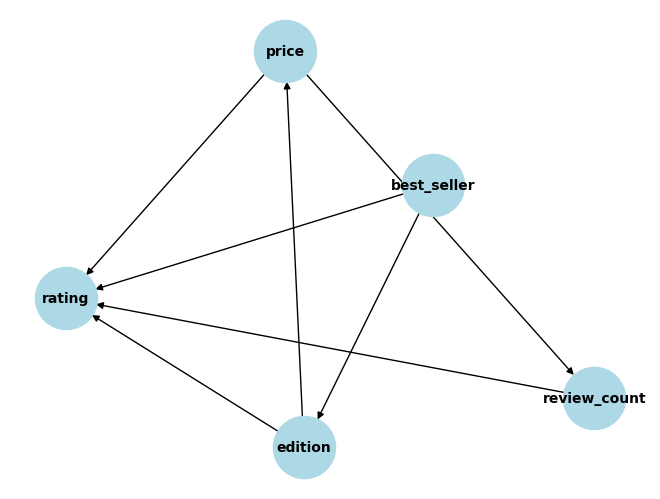

In [38]:
nodes = ['edition', 'best_seller', 'rating', 'review_count', 'price']
edges = [('edition', 'price'),
         ('edition', 'rating'),
         ('price', 'rating'),
         ('best_seller', 'rating'),
         ('best_seller', 'edition'),
         ('review_count','rating'),
         ('price','review_count')]

G_book = nx.DiGraph()


G_book.add_nodes_from(nodes)
G_book.add_edges_from(edges)


pos = nx.spring_layout(G_book)
nx.draw(G_book, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
plt.show()




In [39]:
new_G_book=get_new_G(G_book,bk_df)

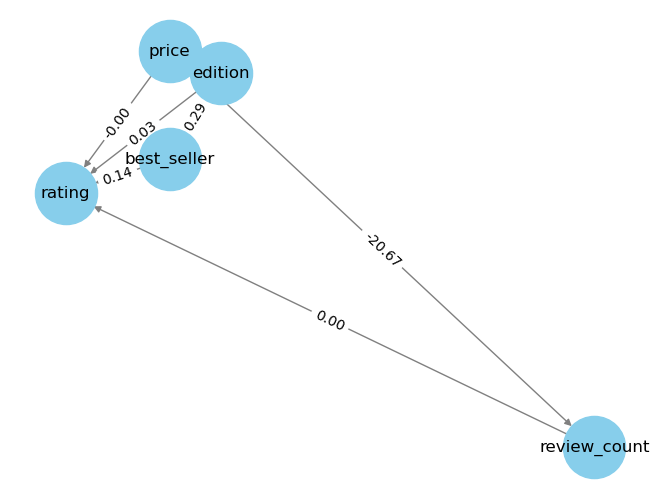

In [40]:
pos = nx.spring_layout(new_G_book)
nx.draw(new_G_book, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G_book.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [41]:
ranking_query(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1})

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
225,Learning eBPF,Programming the Linux Kernel for Enhanced Obse...,Liz Rice,1098135121,978-1098135126,2023-04-11,1.0,0.0,No,5.249291,995.873069,5.0
451,Certified Ethical Hacker (CEH) v12 312-50 Exam...,Keep up to date with ethical hacking trends an...,Dale Meredith,1801813094,978-1801813099,8-Jul-22,1.0,0.0,No,5.207734,831.526444,5.0
321,Configuring Windows Server Hybrid Advanced Ser...,Configure advanced Windows Server services for...,Chris Gill,1804615099,978-1804615096,2023-04-28,1.0,0.0,No,5.207734,828.526444,5.0


In [42]:
tok_k_prob_book = ranking_query_prob(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1})
tok_k_prob_book

,row_index,1,2,3
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,2,0,0.0,0.0
3,3,0,0.0,0.0
4,4,0,0.0,0.0
...,...,...,...,...
536,536,0,0.0,0.0
537,537,0,0.0,0.0
538,538,0,0.0,0.0
539,539,0,0.0,0.0


In [43]:
prob_df_filtered_book=filter_prob_df(tok_k_prob_book)
prob_df_filtered_book

,row_index,1,2,3
225,225,1,0.0,0.0
321,321,0,0.5,0.5
451,451,0,0.5,0.5


In [44]:
calc_prob(prob_df_filtered_book,10)

[{'ranking_combos': (225, 321, 451), 'probabilities': 0.5},
 {'ranking_combos': (225, 451, 321), 'probabilities': 0.5},
 {'ranking_combos': (321, 225, 451), 'probabilities': 0.0},
 {'ranking_combos': (321, 451, 225), 'probabilities': 0.0},
 {'ranking_combos': (451, 225, 321), 'probabilities': 0.0},
 {'ranking_combos': (451, 321, 225), 'probabilities': 0.0}]

In [45]:
get_probs(prob_df_filtered_book, [225,321,451])

0.5

In [46]:
1/(m.perm(541,5)*m.factorial(5))

1.8318183385190886e-16

In [113]:
def stable_ranking(G, df, k, update_vars, target_column, condition=None, max_iter=100):
    i = 0
    rank = ranking_query(G, df, k, update_vars, target_column, condition).index
    x, x_val = next(iter(update_vars.items()))
    x_sd = np.abs(df[x].std() * 0.01)
    x_ival = x_val
    x_val_lb = x_val
    x_upper = None
    x_upper_iter = None
    x_lower = None
    x_lower_iter = None

    while i < max_iter:
        i += 1
        x_val += x_sd
        x_val_lb -= x_sd
        cur_rank_upper = ranking_query(G, df, k, {x: x_val}, target_column, condition).index
        cur_rank_lower = ranking_query(G, df, k, {x: x_val_lb}, target_column, condition).index

        if x_upper is None and not np.array_equal(cur_rank_upper, rank):
            x_upper = x_val - x_ival
            x_upper_iter = i

        if x_lower is None and not np.array_equal(cur_rank_lower, rank):
            x_lower = x_val_lb - x_ival
            x_lower_iter = i
            
        if x_lower is not None and x_upper is not None:
            print(f"Lower Bound Change: (Value: {x_lower}, Iteration: {x_lower_iter})")
            print(f"Upper Bound Change: (Value: {x_upper}, Iteration: {x_upper_iter})")
            return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])

    return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])

In [161]:
def stable_ranking_opt(G, df, k, update_vars, target_column, condition=None, max_iter=100):
    i = 0
    rank = ranking_query(G, df, k, update_vars, target_column, condition).index
    x, x_val = next(iter(update_vars.items()))
    x_sd = np.abs(df[x].std() * 0.01)
    x_ival = x_val
    x_val_lb = x_val
    upper_bound_changed = False
    lower_bound_changed = False
    x_upper = None
    x_lower = None
    x_lower_iter = None
    x_upper_iter = None

    while i < max_iter and not (upper_bound_changed and lower_bound_changed):
        i += 1
        if not upper_bound_changed:
            x_val += x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val}, target_column, condition).index
            if not np.array_equal(cur_rank_upper, rank):
                x_upper = x_val - x_ival
                upper_bound_changed = True
                x_upper_iter = i
        
        if not lower_bound_changed:
            x_val_lb -= x_sd
            cur_rank_lower = ranking_query(G, df, k, {x: x_val_lb}, target_column, condition).index
            if not np.array_equal(cur_rank_lower, rank):
                x_lower = x_val_lb - x_ival
                lower_bound_changed = True
                x_lower_iter = i

    if upper_bound_changed and lower_bound_changed:
        print(f"Lower Bound Change: (Value: {x_lower}, Iteration: {x_lower_iter})")
        print(f"Upper Bound Change: (Value: {x_upper}, Iteration: {x_upper_iter})")
        return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])
    return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])

Linear search, it might increase when delta>8

In [115]:
%%time
stable_ranking(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1})

CPU times: user 2.28 s, sys: 9.9 ms, total: 2.29 s
Wall time: 2.29 s


[[None, 7.850306503581141], [None, 51]]

In [98]:
%%time
stable_ranking(new_G, df, 5, {'age': 3}, 'credit',{'month':3},1000)

CPU times: user 37.2 s, sys: 89.7 ms, total: 37.3 s
Wall time: 37.3 s


((-2.0017357332940042, None), (510, None))

In [99]:
%%time
stable_ranking_opt(new_G, df, 5, {'age': 3}, 'credit',{'month':3},1000)

CPU times: user 27.8 s, sys: 58.3 ms, total: 27.9 s
Wall time: 27.9 s


((-2.0017357332940042, None), (510, None))

In [152]:
def test_revert_ranking(G, df, k, update_vars, target_column, condition=None, prev_max_iter=100, max_iter=100):
    i=0
    rank = ranking_query(G, df, k, update_vars, target_column, condition).index
    x, x_val = next(iter(update_vars.items()))
    x_sd = np.abs(df[x].std() * 0.01)
    prev_results=stable_ranking_opt(G, df, k, update_vars, target_column, condition, prev_max_iter)
    x_val_upper=prev_results[0][1]
    x_upper_iter=prev_results[1][1]
    x_val_lower=prev_results[0][0]
    x_lower_iter=prev_results[1][0]
    while i<max_iter:
        i+=1
        if x_val_upper is not None:
            x_val_upper += x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val_upper+x_val}, target_column, condition).index
            if np.array_equal(cur_rank_upper, rank):
                return([x_val_upper-prev_results[0][1],x_upper_iter+i,"update upper"])
            
        if x_val_lower is not None:
            x_val_lower -= x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val_lower+x_val}, target_column, condition).index
            if np.array_equal(cur_rank_upper, rank):
                return([x_val_lower-prev_results[0][0],x_lower_iter+i,"update lower"])
    return("unable to find the revert ranking")

In [153]:
%%time
test_revert_ranking(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},100,2000)

CPU times: user 2.74 s, sys: 7.48 ms, total: 2.74 s
Wall time: 2.75 s


[13.237771751136826, 137, 'update upper']

In [159]:
ranking_query(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1}).index

Int64Index([225, 451, 321], dtype='int64')

In [155]:
ranking_query(new_G_book, bk_df, 3, {'price':5+7.850306503581141}, 'rating',{'edition':1}).index

Int64Index([451, 225, 321], dtype='int64')

In [156]:
ranking_query(new_G_book, bk_df, 3, {'price':5+7.850306503581141+13.237771751136826}, 'rating',{'edition':1}).index

Int64Index([225, 451, 321], dtype='int64')

In [212]:
def stable_ranking_opt_2(G, df, k, update_vars, target_column, condition=None, max_iter=100):
    i = 0
    rank = ranking_query(G, df, k, update_vars, target_column, condition).index
    x, x_val = next(iter(update_vars.items()))
    x_sd = np.abs(df[x].std() * 0.01)
    x_ival = x_val
    x_val_lb = x_val
    upper_bound_changed = False
    lower_bound_changed = False
    x_upper = None
    x_lower = None
    x_lower_iter = None
    x_upper_iter = None

    while i < max_iter and not (upper_bound_changed and lower_bound_changed):
        i += 1
        if not upper_bound_changed:
            x_val += x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val}, target_column, condition).index
            if not np.array_equal(cur_rank_upper, rank):
                x_upper = x_val
                upper_bound_changed = True
                x_upper_iter = i
        
        if not lower_bound_changed:
            x_val_lb -= x_sd
            cur_rank_lower = ranking_query(G, df, k, {x: x_val_lb}, target_column, condition).index
            if not np.array_equal(cur_rank_lower, rank):
                x_lower = x_val_lb 
                lower_bound_changed = True
                x_lower_iter = i

    if upper_bound_changed and lower_bound_changed:
        print(f"Lower Bound Change: (Value: {x_lower}, Iteration: {x_lower_iter})")
        print(f"Upper Bound Change: (Value: {x_upper}, Iteration: {x_upper_iter})")
        return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])
    return ([[x_lower, x_upper],[x_lower_iter,x_upper_iter]])

In [214]:
stable_ranking_opt_2(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1})

[[None, 12.850306503581141], [None, 51]]

In [232]:
def test_revert_ranking_rec(G, df, k, update_vars, target_column, condition=None, prev_results=None,
                            max_iter=1000,num_iter=0,max_num_iter=1,bond_check='uper'):
    if num_iter>max_num_iter:
        return("the iteration ends")
    i=0
    rank = ranking_query(G, df, k, update_vars, target_column, condition).index
    x, x_val = next(iter(update_vars.items()))
    x_sd = np.abs(df[x].std() * 0.01)
    x_val_upper=prev_results[0][1]
    x_upper_iter=prev_results[1][1]
    x_val_lower=prev_results[0][0]
    x_lower_iter=prev_results[1][0]
    upper_bound_changed = False
    lower_bound_changed = False
    x_pre=None
    
        
    while i<max_iter:
        i+=1
        if x_val_upper is not None and bond_check=='uper' and upper_bound_changed is False:
            x_val_upper += x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val_upper}, target_column, condition).index
            if np.array_equal(cur_rank_upper, rank):
                upper_bound_changed = True
                print([x_val_upper,x_upper_iter+i,"update upper"])
                x_pre=x_val_upper

            
        if x_val_lower is not None and bond_check=='lower' and lower_bound_changed is False:
            x_val_lower -= x_sd
            cur_rank_upper = ranking_query(G, df, k, {x: x_val_lower}, target_column, condition).index
            if np.array_equal(cur_rank_upper, rank):
                lower_bound_changed=True
                print([x_val_lower,x_lower_iter+i,"update lower"])
                x_pre=x_val_lower
    
    if x_pre is not None:
                print(x_pre)
                prev_results=stable_ranking_opt_2(G, df, k, {x: x_pre}, target_column, condition, max_iter)
    else:
        print("no updtaes,increase the max iteration") 
        max_iter+=1000
    num_iter+=1
    return(test_revert_ranking_rec(G, df, k, update_vars, target_column, condition, prev_results,max_iter,num_iter,max_num_iter,bond_check))

In [233]:
prev=stable_ranking_opt_2(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1})
test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},prev,1000,0,3,'uper')

[26.088078254717967, 137, 'update upper']
26.088078254717967
Lower Bound Change: (Value: 25.934150676216376, Iteration: 1)
Upper Bound Change: (Value: 33.01481928728954, Iteration: 45)
no updtaes,increase the max iteration
no updtaes,increase the max iteration
no updtaes,increase the max iteration


'the iteration ends'

In [287]:
def comp_rank_k_grouped(df, y, k, group_col):
    """
    df: dataframe
    y: the target node
    k: numbers of element in a comparision,[e1,e2,...ek]
    group_col: the column will be used for groupby
    """
    group_means = df.groupby(group_col)[y].mean().reset_index(name='mean_score')
    prob_df = pd.DataFrame(0, index=group_means.index, columns=range(1, k+1))
    prob_df['group_col'] = group_means[group_col]

    cols = prob_df.columns.tolist()[:-1]
    cols.insert(0, 'group_col')
    prob_df = prob_df[cols]
    scores = group_means['mean_score'].tolist()
    
    for rank in range(1, k + 1):
        for i, score in enumerate(scores):
            higher_counts = sum(1 for s in scores if s > score)
            same_counts = sum(1 for s in scores if s == score)
            if higher_counts < rank <= higher_counts + same_counts:
                prob_df.loc[i, rank] = 1 / same_counts
    
    return prob_df

In [294]:
def ranking_query_prob_grouped(G, df, k, update_vars, target_column, group_col, condition=None):
    """
    G: the causal graph
    df:  dataframe
    k: the top k
    update_vars: the variables need to be updated with the value
    target_column: the column we will rank by
    condition:the condtion to filter rows
    group_col: the group by column
    """
    df_temp = df.copy()
    if condition:
        condition_mask = df_temp[list(condition.keys())].eq(pd.Series(condition)).all(axis=1)
    else:
        condition_mask = pd.Series([True]*len(df_temp))

    for var, value in update_vars.items():
        temp_lst=df_temp.loc[condition_mask, var]
        delta = [value - x for x in temp_lst]
        adjust_node(var, delta, df_temp, G, condition_mask,value,True)
    
    prob_df=comp_rank_k_grouped(df_temp,target_column, k,group_col)
    
    return prob_df

In [295]:
def filter_prob_df_grouped(df):
    """
    df: a probility dataframe generated by ranking_query_prob
    """
    df_edit = df.columns[1:-1]
    filtered_df = df.loc[df[df_edit].apply(lambda x: any(v != 0 for v in x), axis=1)]
    return filtered_df

In [296]:
rank_rating_by_ed=ranking_query_prob_grouped(new_G_book, bk_df, 3, {'price':5}, 'rating','edition',{'edition':1})
filter_prob_df_grouped(rank_rating_by_ed)

,group_col,1,2,3
5,6.0,1,0.0,0.0
7,8.0,0,0.5,0.5
8,10.0,0,0.5,0.5


In [293]:
G=new_G_book
df=bk_df
k=3
update_vars={'price':5}
target_column='rating'
group_col='edition'
condition={'edition':1}
df_temp = df.copy()
    #filter rows with the condtions
if condition:
    condition_mask = df_temp[list(condition.keys())].eq(pd.Series(condition)).all(axis=1)
else:
    condition_mask = pd.Series([True]*len(df_temp))

for var, value in update_vars.items():
    temp_lst=df_temp.loc[condition_mask, var]
    delta = [value - x for x in temp_lst]
    adjust_node(var, delta, df_temp, G, condition_mask,value,True)
df_temp.groupby('edition')['rating'].mean().reset_index(name='mean_score')

,edition,mean_score
0,1.0,4.596819
1,2.0,4.631481
2,3.0,4.500000
3,4.0,4.544444
4,5.0,4.600000
5,6.0,4.725000
6,7.0,4.516667
7,8.0,4.700000
8,10.0,4.700000
9,2015.0,4.400000


In [266]:
bk_df.groupby('edition')['rating'].mean().reset_index(name='mean_score')

,edition,mean_score
0,1.0,4.466763
1,2.0,4.631481
2,3.0,4.500000
3,4.0,4.544444
4,5.0,4.600000
5,6.0,4.725000
6,7.0,4.516667
7,8.0,4.700000
8,10.0,4.700000
9,2015.0,4.400000
